Importing all required dependencies

In [374]:
from itertools import product
from collections import defaultdict
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cosine
import pulp
import gensim
from sklearn.metrics.pairwise import cosine_similarity
import json

Importing Word2Vec model (https://code.google.com/archive/p/word2vec/). The next block may require a long time!

In [15]:
wvmodel = gensim.models.KeyedVectors.load_word2vec_format(r'C:\Users\User\Desktop\projectIR\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True)

Testing Word2Vec model (@Mario: Nota quanto cazzo è incredibile sta cosa)

In [16]:
x_test = wvmodel['man']+wvmodel['king']-wvmodel['woman']
y_test = wvmodel['queen']
z_test = wvmodel['boat']

In [17]:
print(cosine_similarity([x_test], [y_test]))
print(cosine_similarity([x_test], [z_test]))

[[0.4057604]]
[[0.01503608]]


Here we initialize the collection&nbsp;. https://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.html &nbsp;
We use the smaller dataset (called mini). We tokenize all documents and assign to every document an unique ID and a label (depending on the group it came from). 

In [18]:
# To do, parse all documents and get the list of tokens (We remove capital letters?)

Useful functions

In [19]:
def merge_two_dicts(x, y):
    z = x.copy()   # start with x's keys and values
    z.update(y)    # modifies z with y's keys and values & returns None
    return z

In [86]:
def dot_product_lists(a,b):
    return sum([x*y for x,y in zip(a,b)])

In [184]:
def wme_to_wmd(x,y,gamma):
    kxy = dot_product_lists(x,y)
    return -1/gamma*np.log(kxy)

Implementation of Word Mover Distance (solved through LP). Next two blocks from: https://github.com/stephenhky/PyWM

In [20]:
def tokens_to_fracdict(tokens):
    cntdict = defaultdict(lambda : 0)
    for token in tokens:
        cntdict[token] += 1
    totalcnt = sum(cntdict.values())
    return {token: float(cnt)/totalcnt for token, cnt in cntdict.items()}

In [21]:
def word_mover_distance_probspec(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=None):
    all_tokens = list(set(first_sent_tokens+second_sent_tokens))
    wordvecs = {token: wvmodel[token] for token in all_tokens}

    first_sent_buckets = tokens_to_fracdict(first_sent_tokens)
    second_sent_buckets = tokens_to_fracdict(second_sent_tokens)

    T = pulp.LpVariable.dicts('T_matrix', list(product(all_tokens, all_tokens)), lowBound=0)

    prob = pulp.LpProblem('WMD', sense=pulp.LpMinimize)
    prob += pulp.lpSum([T[token1, token2]*euclidean(wordvecs[token1], wordvecs[token2])
                        for token1, token2 in product(all_tokens, all_tokens)])
    for token2 in second_sent_buckets:
        prob += pulp.lpSum([T[token1, token2] for token1 in first_sent_buckets])==second_sent_buckets[token2]
    for token1 in first_sent_buckets:
        prob += pulp.lpSum([T[token1, token2] for token2 in second_sent_buckets])==first_sent_buckets[token1]

    if lpFile!=None:
        prob.writeLP(lpFile)

    prob.solve()

    return prob

In [22]:
def WMD_regular(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=None):
    prob = word_mover_distance_probspec(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=lpFile)
    return pulp.value(prob.objective)

We need to define WMD also for a random document with random words

In [23]:
def word_mover_distance_random(documents_token, random_document_vectors, wvmodel, lpFile=None):
    #We create a random association between the random_document_vectors and tokens, assuming random vectors to be all different
    first_sent_tokens = documents_token
    second_sent_tokens = ['__qxvca^&3fd?#_!$' +  str(i) for i in range(len(random_document_vectors))]
    
    all_tokens = list(set(first_sent_tokens+second_sent_tokens))
    wordvecs_document = {token: wvmodel[token] for token in first_sent_tokens}
    wordvecs_random = {second_sent_tokens[i]: random_document_vectors[i] for i in range(len(random_document_vectors))}
    #print(wordvecs_random)
    wordvecs = merge_two_dicts(wordvecs_document,wordvecs_random)

    first_sent_buckets = tokens_to_fracdict(first_sent_tokens)
    second_sent_buckets = tokens_to_fracdict(second_sent_tokens)

    T = pulp.LpVariable.dicts('T_matrix', list(product(all_tokens, all_tokens)), lowBound=0)

    prob = pulp.LpProblem('WMD', sense=pulp.LpMinimize)
    prob += pulp.lpSum([T[token1, token2]*euclidean(wordvecs[token1], wordvecs[token2])
                        for token1, token2 in product(all_tokens, all_tokens)])
    for token2 in second_sent_buckets:
        prob += pulp.lpSum([T[token1, token2] for token1 in first_sent_buckets])==second_sent_buckets[token2]
    for token1 in first_sent_buckets:
        prob += pulp.lpSum([T[token1, token2] for token2 in second_sent_buckets])==first_sent_buckets[token1]

    if lpFile!=None:
        prob.writeLP(lpFile)

    prob.solve()

    return prob

In [24]:
def WMD_random(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=None):
    prob = word_mover_distance_random(first_sent_tokens, second_sent_tokens, wvmodel, lpFile=lpFile)
    return pulp.value(prob.objective)

Test WMD functions

In [196]:
print(WMD_regular(['hi','bye'],['see','you'],wvmodel))
print(WMD_random(['hi','bye'],[wvmodel['see'],wvmodel['you']],wvmodel))

3.6146241426467896
3.6146241426467896


Implementation of the WME 

In [26]:
def WME_phi(x,w,gamma,wvmodel):
    return np.exp( -gamma*WMD_random(x,w,wvmodel))

In [317]:
def calculate_WME(documents, D_max, R, wvmodel):
    # It must returns a list of text embeddings, i-th element being the embedding of the i-th document
    
    #Phase 1: Compute v_max and v_min
    v_values = [+9999,-9999] # [v_min,v_max]
    for doc in documents:
        for token in doc:
            for x in wvmodel[token]:
                v_values[0] = min(v_values[0],x)
                v_values[1] = max(v_values[1],x)
            
    print("[v_min, v_max] = "  + str(v_values))
    Z = []
    for j in range(R):
        print("R: " + str(j+1)+"/"+str(R))
        D = 1 + np.random.randint(D_max)
        random_doc = []
        for l in range(D):
            word = np.random.uniform(v_values[0],v_values[1],size=300)
            word = word*1/np.sqrt(sum(x*x for x in word))
            random_doc.append(word)
        to_add = [WME_phi(doc,random_doc,1.12,wvmodel) for doc in documents]
        #print("to_add" + str(to_add))
        Z.append(to_add)
    ret_Z = (1/(np.sqrt(R))*np.array(Z).T).tolist()
    return ret_Z
        
        
    

In [219]:
documents = [['the','sun','is','the','best','thing','in','the','world'],['i','love','watch','the','sun','it','burns','my','life']]

In [220]:
print(WMD_regular(documents[0],documents[0],wvmodel))
print(wvmodel['the'])
print(sum(x*x for x in wvmodel['queen']))

0.0
[ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.18652344

In [226]:
WME_embedding = calculate_WME(documents,21,100,wvmodel)
#WME_embedding[i] is the embedding of the i-th element and consists of R features

1.0000000000000004
to_add[0.08847710156751941, 0.04710078762292685]
1.0000000000000002
1.0000000000000009
1.0000000000000004
1.0000000000000013
0.9999999999999998
1.0000000000000004
1.0000000000000009
1.0
to_add[0.09655539951030856, 0.05200863951631779]
1.0000000000000002
1.0
0.9999999999999994
0.9999999999999994
1.0000000000000009
0.9999999999999992
1.0000000000000004
1.0000000000000007
1.0000000000000009
0.9999999999999998
0.9999999999999991
1.0000000000000004
0.9999999999999998
1.000000000000001
0.9999999999999994
1.0000000000000002
1.0000000000000004
1.0000000000000002
0.9999999999999994
0.999999999999999
0.9999999999999994
to_add[0.09920844845796649, 0.053481110961832036]
0.9999999999999994
0.9999999999999999
0.9999999999999999
1.0000000000000016
0.9999999999999999
1.0000000000000004
0.9999999999999991
1.000000000000001
0.9999999999999999
1.0000000000000002
0.9999999999999994
0.9999999999999996
1.0000000000000002
0.9999999999999997
1.0000000000000016
1.0000000000000002
1.000000000

to_add[0.09670313114077705, 0.0523728849187205]
0.9999999999999989
1.0
to_add[0.09362790149656978, 0.050297668177008814]
0.9999999999999998
1.0
0.9999999999999997
0.9999999999999994
0.9999999999999997
1.0000000000000004
1.0
0.9999999999999997
1.0000000000000018
to_add[0.09793038115378862, 0.05238148338422674]
0.9999999999999993
1.0
0.9999999999999988
0.9999999999999998
1.0
1.0000000000000009
1.0000000000000002
0.9999999999999993
0.9999999999999997
0.9999999999999996
1.0
0.9999999999999998
0.9999999999999996
to_add[0.09647167783229207, 0.05231102755605944]
0.9999999999999993
0.9999999999999994
0.9999999999999993
1.0000000000000007
0.999999999999999
0.9999999999999997
1.0000000000000007
1.0000000000000007
1.0000000000000007
0.9999999999999999
1.0000000000000009
0.9999999999999998
1.000000000000001
1.0000000000000007
0.9999999999999994
1.0000000000000009
0.9999999999999996
1.0000000000000004
1.0000000000000002
0.9999999999999988
0.9999999999999996
to_add[0.09781962159991804, 0.05200747203

to_add[0.09595466656563667, 0.05204731420447341]
0.9999999999999999
1.0000000000000007
0.9999999999999998
1.0000000000000007
0.999999999999999
0.9999999999999999
0.9999999999999996
1.0000000000000004
to_add[0.09648428186490589, 0.05115990063855316]
1.0000000000000002
0.9999999999999997
0.9999999999999981
1.0000000000000002
0.9999999999999993
1.0
0.9999999999999996
0.9999999999999993
to_add[0.09683026724624391, 0.051973390833404125]
0.9999999999999996
0.9999999999999987
1.0000000000000013
0.9999999999999993
0.9999999999999996
1.0000000000000007
0.9999999999999997
to_add[0.09721719078215642, 0.051894312428845735]
0.9999999999999992
0.9999999999999983
to_add[0.0968332579761388, 0.04938644073845244]
0.9999999999999983
1.0000000000000004
0.9999999999999998
0.9999999999999996
1.0000000000000007
1.0000000000000007
0.9999999999999999
0.9999999999999998
1.0000000000000009
to_add[0.09752032588945914, 0.05094634497193794]
1.0000000000000007
1.0000000000000007
1.0000000000000004
1.0000000000000002

In [227]:
print(wme_to_wmd(WME_embedding[0],WME_embedding[0],1.12))
print(wme_to_wmd(WME_embedding[0],WME_embedding[1],1.12))

4.172555813880079
4.735544659769966


In [228]:
print(WME_embedding[0])

[0.008847710156751941, 0.009655539951030856, 0.00992084484579665, 0.009732296202179766, 0.010070816473737733, 0.009824771240519439, 0.00968933204917983, 0.009675287656190856, 0.009763331584900784, 0.009882721734152583, 0.009604000692471516, 0.009785913611048766, 0.009710426735844241, 0.009317878344238585, 0.009655474685302224, 0.009529380807194997, 0.009393487019516783, 0.009942839477067943, 0.009852187917713334, 0.00973469689927381, 0.009739552885316215, 0.009645084594359848, 0.009833686058111583, 0.009711184088083101, 0.0097871154311626, 0.009711188491574969, 0.009657973808752577, 0.009648814139109, 0.009641069326843468, 0.009876992778256703, 0.009670313114077705, 0.009362790149656979, 0.009793038115378863, 0.009647167783229209, 0.009781962159991804, 0.009637036758061898, 0.009742917211721639, 0.009735938150959085, 0.009811803583381781, 0.009806496520920405, 0.009671383935629819, 0.009862036059433785, 0.009685596844952212, 0.009635575435377937, 0.00979325763958102, 0.0098062964334909

In [391]:
#It returns a list of k_max elements, iteratively picked using the farthest-first traversal algorithm
# The returned list [a_1, ..., a_(k_max)] containts the indexes of the picked element at every iteration (i.e. a_i is selected in the i-th iteration)
# documents in this case containts the (ordered) list of the embeddings of the documents
def k_center(documents,k_max):
    ret = []
    radius = []
    N = len(documents)
    first = np.random.randint(N)
    ret.append(first)
    
    dist = [euclidean(doc,documents[first]) for doc in documents] 
   
    radius.append(np.max(dist))
    for k in range(k_max-1):
        #Selection
        j = np.argmax(dist)
        ret.append(j)
        
        #Update
        dist = [min(dist[i], euclidean(documents[i],documents[j])) for i in range(N)]
       
        radius.append(np.max(dist))
    return ret,radius
        
        
        
    

In [175]:
centers,radius = k_center(WME_embedding,2,1.12)
print(centers)
print(radius)

[12.5592839355294, 12.772437054200639]
[12.5592839355294, 12.772437054200639]
[1, 1]
[12.772437054200639, 12.772437054200639]


In [177]:
train_json_data = open('recipe_dataset/train.json')
test_json_data = open('recipe_dataset/test.json')
train_data = json.load(train_json_data)
test_data = json.load(test_json_data)

print(len(train_data))
print(train_data[0]['cuisine'])
print(train_data[0]['ingredients'])

39774
greek
['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles']


In [292]:
dataset = train_data
m_test = len(dataset)
print("Lenght of dataset: " + str(m_test))
train_X = []
for i in range(m_test):
    doc = [x.split() for x in dataset[i]['ingredients']]
    doc = sum(doc,[])
    #print(doc)
    doc = [x for x in doc if x in wvmodel]
    train_X.append(doc)

Lenght of dataset: 39774


In [303]:
train_Y = []
for i in range(m_test):
    train_Y.append(dataset[i]['cuisine'])
print(train_Y)

['greek', 'southern_us', 'filipino', 'indian', 'indian', 'jamaican', 'spanish', 'italian', 'mexican', 'italian', 'italian', 'chinese', 'italian', 'mexican', 'italian', 'indian', 'british', 'italian', 'thai', 'vietnamese', 'thai', 'mexican', 'southern_us', 'chinese', 'italian', 'chinese', 'cajun_creole', 'italian', 'chinese', 'mexican', 'italian', 'cajun_creole', 'mexican', 'thai', 'italian', 'cajun_creole', 'italian', 'filipino', 'southern_us', 'southern_us', 'italian', 'brazilian', 'mexican', 'indian', 'mexican', 'chinese', 'french', 'southern_us', 'southern_us', 'southern_us', 'japanese', 'southern_us', 'italian', 'southern_us', 'italian', 'jamaican', 'japanese', 'indian', 'italian', 'irish', 'thai', 'thai', 'indian', 'jamaican', 'italian', 'thai', 'korean', 'french', 'french', 'southern_us', 'spanish', 'indian', 'moroccan', 'italian', 'italian', 'moroccan', 'moroccan', 'vietnamese', 'japanese', 'mexican', 'cajun_creole', 'southern_us', 'french', 'indian', 'indian', 'italian', 'itali

In [315]:
#Reduce the size of the training dataset
NUMBER_OF_POINTS = 1024
index_to_pick = [i for i in range(m_test)]
np.random.shuffle(index_to_pick)
#print(index_to_pick[0:1024])
train_R_X = [train_X[i] for i in index_to_pick[0:NUMBER_OF_POINTS]]
train_R_Y = [train_Y[i] for i in index_to_pick[0:NUMBER_OF_POINTS]]
print("Number of classes: ",len(set(train_R_Y)))

Number of classes:  20


CARE! The next line of code is computationally expensive! (Disabled)

In [318]:
#train_embedding = calculate_WME(train_R_X,6,32,wvmodel)

[v_min, v_max] = [-1.03125, 1.0859375]
R: 1/32
R: 2/32
R: 3/32
R: 4/32
R: 5/32
R: 6/32
R: 7/32
R: 8/32
R: 9/32
R: 10/32
R: 11/32
R: 12/32
R: 13/32
R: 14/32
R: 15/32
R: 16/32
R: 17/32
R: 18/32
R: 19/32
R: 20/32
R: 21/32
R: 22/32
R: 23/32
R: 24/32
R: 25/32
R: 26/32
R: 27/32
R: 28/32
R: 29/32
R: 30/32
R: 31/32
R: 32/32


The next block can be used to save the trained model

import pickle
obj = ['recipe_dataset', train_R_X, train_R_Y, index_to_pick, train_embedding]
f = open('recipes_WME.pckl', 'wb')
pickle.dump(obj, f)
f.close()

The next block can be used to load the trained model

import pickle
f = open('recipes_WME.pckl', 'rb')
obj = pickle.load(f)
f.close()
train_R_X = obj[1]
train_R_Y = obj[2]
index_to_pick = obj[3]
train_embedding = obj[4]

In [392]:
elements_to_pick = 150
centers,radius = k_center(train_embedding,elements_to_pick)

In [394]:
sets_label = set()
k_center_number = []
for i in range(elements_to_pick):
    sets_label.add(train_R_Y[centers[i]])
    k_center_number.append(len(sets_label))
    

In [384]:
random_indexes = [i for i in range(NUMBER_OF_POINTS)]
np.random.shuffle(random_indexes)
sets_label = set()
random_number = [0]*elements_to_pick
NUMBER_ITERATIONS = 100000 #Reduce if too much expensive
for j in range(NUMBER_ITERATIONS):
    sets_label = set()
    for i in range(150):
        sets_label.add(train_R_Y[random_indexes[i]])
        random_number[i] += 1.0/NUMBER_ITERATIONS*len(sets_label)

In [395]:
import matplotlib.pyplot as plt

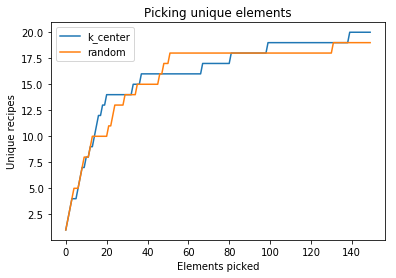

In [401]:
x = [i for i in range(elements_to_pick)]

plt.plot(x, k_center_number, label='k_center')
plt.plot(x, random_number, label='random')

plt.xlabel('Elements picked')
plt.ylabel('Unique recipes')

plt.title("Picking unique elements")

plt.legend()

plt.show()

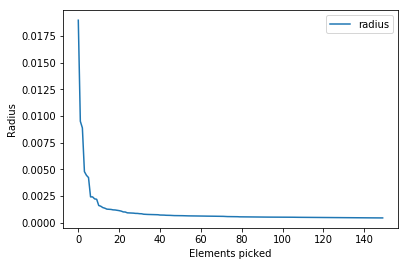

In [400]:
x = [i for i in range(150)]

plt.plot(x, radius, label='radius')
plt.xlabel('Elements picked')
plt.ylabel('Radius')
plt.legend()
plt.show()